#### Importing requred libraries

In [1]:
# Installing sci-kit multiflow
!pip install -U git+https://github.com/itzsanjus/scikit-multiflow

  Cloning https://github.com/itzsanjus/scikit-multiflow to /tmp/pip-req-build-_r6ci348
  Running command git clone --filter=blob:none --quiet https://github.com/itzsanjus/scikit-multiflow /tmp/pip-req-build-_r6ci348
  Resolved https://github.com/itzsanjus/scikit-multiflow to commit acad6bdd954b5bb997ed4f4d86b144a78ad0ea6e
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.6.dev0-cp310-cp310-linux_x86_64.whl size=1328158 sha256=c05094733ab803ba918a5f82cdd8540f89b04408ed06e21d8d6f870e6b1fc16a
  Stored in directory: /tmp/pip-ephem-wheel-cache-hixhfd3i/wheels/6b/81/fe/e83e8d80836d4532a8deea3792f37600fd8c12a31200af6294
Successfully built scikit-multiflow


In [ ]:
# These packages are for Data manipulation.
import pandas as pd
import numpy as np
# These packages are useful data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Useful for Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skmultiflow.evaluation import EvaluatePrequential
# These packages are useful for model evaluation
from sklearn import metrics
from sklearn.metrics import roc_auc_score

#### Class of the model

In [ ]:
import xgboost as xgb
from skmultiflow.core.base import BaseSKMObject, ClassifierMixin
from skmultiflow.drift_detection import ADWIN
from skmultiflow.utils import get_dimensions


class AdaptiveXGBoostClassifier(BaseSKMObject, ClassifierMixin):
    _PUSH_STRATEGY = 'push'
    _REPLACE_STRATEGY = 'replace'
    _UPDATE_STRATEGIES = [_PUSH_STRATEGY, _REPLACE_STRATEGY]

    def __init__(self,
                 n_estimators=30,
                 learning_rate=0.3,
                 max_depth=6,
                 max_window_size=1000,
                 min_window_size=None,
                 detect_drift=False,
                 update_strategy='replace'):
        """
        Adaptive XGBoost classifier.

        Parameters
        ----------
        n_estimators: int (default=5)
            The number of estimators in the ensemble.

        learning_rate:
            Learning rate, a.k.a eta.

        max_depth: int (default = 6)
            Max tree depth.

        max_window_size: int (default=1000)
            Max window size.

        min_window_size: int (default=None)
            Min window size. If this parameters is not set, then a fixed size
            window of size ``max_window_size`` will be used.

        detect_drift: bool (default=False)
            If set will use a drift detector (ADWIN).

        update_strategy: str (default='replace')
            | The update strategy to use:
            | 'push' - the ensemble resembles a queue
            | 'replace' - oldest ensemble members are replaced by newer ones

        Notes
        -----
        The Adaptive XGBoost [1]_ (AXGB) classifier is an adaptation of the
        XGBoost algorithm for evolving data streams. AXGB creates new members
        of the ensemble from mini-batches of data as new data becomes
        available.  The maximum ensemble  size is fixed, but learning does not
        stop once this size is reached, the ensemble is updated on new data to
        ensure consistency with the current data distribution.

        References
        ----------
        .. [1] Montiel, Jacob, Mitchell, Rory, Frank, Eibe, Pfahringer,
           Bernhard, Abdessalem, Talel, and Bifet, Albert. “AdaptiveXGBoost for
           Evolving Data Streams”. In:IJCNN’20. International Joint Conference
           on Neural Networks. 2020. Forthcoming.
        """
        super().__init__()
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_window_size = max_window_size
        self.min_window_size = min_window_size
        self._first_run = True
        self._ensemble = None
        self.detect_drift = detect_drift
        self._drift_detector = None
        self._X_buffer = np.array([])
        self._y_buffer = np.array([])
        self._samples_seen = 0
        self._model_idx = 0
        self.tree_method = "gpu_hist"
        if update_strategy not in self._UPDATE_STRATEGIES:
            raise AttributeError("Invalid update_strategy: {}\n"
                                 "Valid options: {}".format(update_strategy,
                                                            self._UPDATE_STRATEGIES))
        self.update_strategy = update_strategy
        self._configure()

    def _configure(self):
        if self.update_strategy == self._PUSH_STRATEGY:
            self._ensemble = []
        elif self.update_strategy == self._REPLACE_STRATEGY:
            self._ensemble = [None] * self.n_estimators
        self._reset_window_size()
        self._init_margin = 0.0
        self._boosting_params = {"silent": True,
                                 "objective": "binary:logistic",
                                 "eta": self.learning_rate,
                                 "max_depth": self.max_depth}
        if self.detect_drift:
            self._drift_detector = ADWIN()

    def reset(self):
        """
        Reset the estimator.
        """
        self._first_run = True
        self._configure()

    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """
        Partially (incrementally) fit the model.

        Parameters
        ----------
        X: numpy.ndarray
            An array of shape (n_samples, n_features) with the data upon which
            the algorithm will create its model.

        y: Array-like
            An array of shape (, n_samples) containing the classification
            targets for all samples in X. Only binary data is supported.

        classes: Not used.

        sample_weight: Not used.

        Returns
        -------
        AdaptiveXGBoostClassifier
            self
        """
        for i in range(X.shape[0]):
            self._partial_fit(np.array([X[i, :]]), np.array([y[i]]))
        return self

    def _partial_fit(self, X, y):
        if self._first_run:
            self._X_buffer = np.array([]).reshape(0, get_dimensions(X)[1])
            self._y_buffer = np.array([])
            self._first_run = False
        self._X_buffer = np.concatenate((self._X_buffer, X))
        self._y_buffer = np.concatenate((self._y_buffer, y))
        while self._X_buffer.shape[0] >= self.window_size:
            self._train_on_mini_batch(X=self._X_buffer[0:self.window_size, :],
                                      y=self._y_buffer[0:self.window_size])
            delete_idx = [i for i in range(self.window_size)]
            self._X_buffer = np.delete(self._X_buffer, delete_idx, axis=0)
            self._y_buffer = np.delete(self._y_buffer, delete_idx, axis=0)

            # Check window size and adjust it if necessary
            self._adjust_window_size()

        # Support for concept drift
        if self.detect_drift:
            correctly_classifies = self.predict(X) == y
            # Check for warning
            self._drift_detector.add_element(int(not correctly_classifies))
            # Check if there was a change
            if self._drift_detector.detected_change():
                # Reset window size
                self._reset_window_size()
                if self.update_strategy == self._REPLACE_STRATEGY:
                    self._model_idx = 0

    def _adjust_window_size(self):
        if self._dynamic_window_size < self.max_window_size:
            self._dynamic_window_size *= 2
            if self._dynamic_window_size > self.max_window_size:
                self.window_size = self.max_window_size
            else:
                self.window_size = self._dynamic_window_size

    def _reset_window_size(self):
        if self.min_window_size:
            self._dynamic_window_size = self.min_window_size
        else:
            self._dynamic_window_size = self.max_window_size
        self.window_size = self._dynamic_window_size

    def _train_on_mini_batch(self, X, y):
        if self.update_strategy == self._REPLACE_STRATEGY:
            booster = self._train_booster(X, y, self._model_idx)
            # Update ensemble
            self._ensemble[self._model_idx] = booster
            self._samples_seen += X.shape[0]
            self._update_model_idx()
        else:   # self.update_strategy == self._PUSH_STRATEGY
            booster = self._train_booster(X, y, len(self._ensemble))
            # Update ensemble
            if len(self._ensemble) == self.n_estimators:
                self._ensemble.pop(0)
            self._ensemble.append(booster)
            self._samples_seen += X.shape[0]

    def _train_booster(self, X: np.ndarray, y: np.ndarray, last_model_idx: int):
        d_mini_batch_train = xgb.DMatrix(X, y.astype(int))
        # Get margins from trees in the ensemble
        margins = np.asarray([self._init_margin] * d_mini_batch_train.num_row())
        for j in range(last_model_idx):
            margins = np.add(margins,
                             self._ensemble[j].predict(d_mini_batch_train, output_margin=True))
        d_mini_batch_train.set_base_margin(margin=margins)
        booster = xgb.train(params=self._boosting_params,
                            dtrain=d_mini_batch_train,
                            num_boost_round=1,
                            verbose_eval=False)
        return booster

    def _update_model_idx(self):
        self._model_idx += 1
        if self._model_idx == self.n_estimators:
            self._model_idx = 0

    def predict(self, X):
        """
        Predict the class label for sample X

        Parameters
        ----------
        X: numpy.ndarray
            An array of shape (n_samples, n_features) with the samples to
            predict the class label for.

        Returns
        -------
        numpy.ndarray
            A 1D array of shape (, n_samples), containing the
            predicted class labels for all instances in X.

        """
        if self._ensemble:
            if self.update_strategy == self._REPLACE_STRATEGY:
                trees_in_ensemble = sum(i is not None for i in self._ensemble)
            else:   # self.update_strategy == self._PUSH_STRATEGY
                trees_in_ensemble = len(self._ensemble)
            if trees_in_ensemble > 0:
                d_test = xgb.DMatrix(X)
                for i in range(trees_in_ensemble - 1):
                    margins = self._ensemble[i].predict(d_test, output_margin=True)
                    d_test.set_base_margin(margin=margins)
                predicted = self._ensemble[trees_in_ensemble - 1].predict(d_test)
                return np.array(predicted > 0.5).astype(int)
        # Ensemble is empty, return default values (0)
        return np.zeros(get_dimensions(X)[0])

    def predict_proba(self, X):
        """
        Not implemented for this method.
        """
        raise NotImplementedError("predict_proba is not implemented for this method.")

#### Reading CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sanju Sarkar/dataset.csv')

#### Overview of the Dataset

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.tail()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
print("Number of records:\t",df.shape[0])
print("Number of features:\t",df.shape[1])

In [ ]:
df['isFraud'].unique()

**Insights**
* The dataset consist of **11 columns**.
* We have **5 columns** of float datatype.
* We have **3 columns** of integer datatype.
* We have **3 columns** of object datatype.
* The dataset contains **6362620** rows of data
* This is a **Binary Classification** Problem

#### Data Cleaning

In [ ]:
print('Missing value count: ',df.isnull().sum().sum())

In [ ]:
print('Number of duplicates are : ', df.duplicated().sum())

In [ ]:
print("Number of transactions with amount is less 0?")
print(len(df[df.amount<0]))

In [ ]:
print("Number of transactions with amount is equal to 0?")
print(len(df[df.amount==0]))

#### Exploratory Data Analysis

##### Checking how many transactions are fraud

In [ ]:
df['isFraud'].value_counts()

In [ ]:
df['type'].value_counts()

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

In [ ]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df, x = "type", hue="isFraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

##### Checking if the reciever and trasfer account are same

In [ ]:
fraud_trans = df[df['isFraud'] == 1]
valid_trans = df[df['isFraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Has the receiving account used for cashing out?')
trans_transfer.nameDest.isin(trans_cashout.nameOrig).any()

##### Checking correlations among features

In [ ]:
lst= ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']
df_corr= df[lst].corr()
plt.figure(figsize= (25,15))
sns.heatmap(df_corr,annot= True)
plt.show()

##### Checking which type has the fraudulent transactions

In [ ]:
fraud_size=df[df['isFraud'].isin([1])].groupby(['type']).size()
fraud_size

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(fraud_size.values,labels=fraud_size.index, autopct='%.6f%%')
plt.title("Transaction Type")
plt.show()

##### Checking the origin where the transcations were made

In [ ]:
transfer_fraud = df[((df['type']=='TRANSFER') & df['isFraud']==1)]
transfer_fraud['nameOrig'].value_counts()

##### Checking the Destination from where the transactions were cashed out

In [ ]:
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]
cash_out_fraud['nameDest'].value_counts()

In [ ]:
df_temp = df[df.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print(len(df_temp))
print("What type of transactions are they?")
print(df_temp['type'].value_counts().index[0])
print("Are all these flagged also marked as Fraud Transactions?")
print(df_temp['isFraud'].value_counts()[1] == len(df_temp))

In [ ]:
fraud_step = df[df['isFraud'].isin([1])].groupby(['step']).size()
print("Step wise fraud transcations percentage: ",(fraud_step.count()/df['step'].unique().shape[0])*100)

In [ ]:
fraud_step.plot(kind='bar',figsize=(40,45))

**Insights**
* Our fraud transactions are done in **TRANSFER** and **CASH_OUT** transaction type.
* The fraud transactions in **TRANSFER** were **4097** and **CASH_OUT** were **4116**.
* The **fraud** transactions were generally from **Customer to Customer**
* The transactions account used for **Recieving and Sending was not Same** in case of **Fraud transactions**.
* In 99% steps there are fraudelent transactions.
* All flagged transactions are marked as fraud transaction

#### Feature Engineering

In [ ]:
'''Payment, Debit, Cash_In is kept in Others category as they have less number of fraudulent transactions'''
def feature_engineering(data):
  new_type = {'PAYMENT':'OTHERS', 'TRANSFER':'TRANSFER', 'CASH_OUT':'CASH_OUT', 'DEBIT':'OTHERS', 'CASH_IN':'OTHERS'}
  data['type']=data['type'].map(new_type)
  '''
  Another column type2 is created where the transaction sender and reciever is categorized.
  '''
  data['type2'] = np.nan
  data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'
  data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'), 'type2'] = 'CM'
  data.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MC'
  data.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MM'
  data.drop(columns = ['nameOrig','nameDest'], axis = 'columns', inplace = True)
  return data

In [ ]:
data = feature_engineering(df)

In [ ]:
fraud_trans = data[data['isFraud'] == 1]
valid_trans = data[data['isFraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts())
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 CC    8213
Name: type2, dtype: int64
Number of valid transactions according to type are below:
 CC    4202912
CM    2151495
Name: type2, dtype: int64


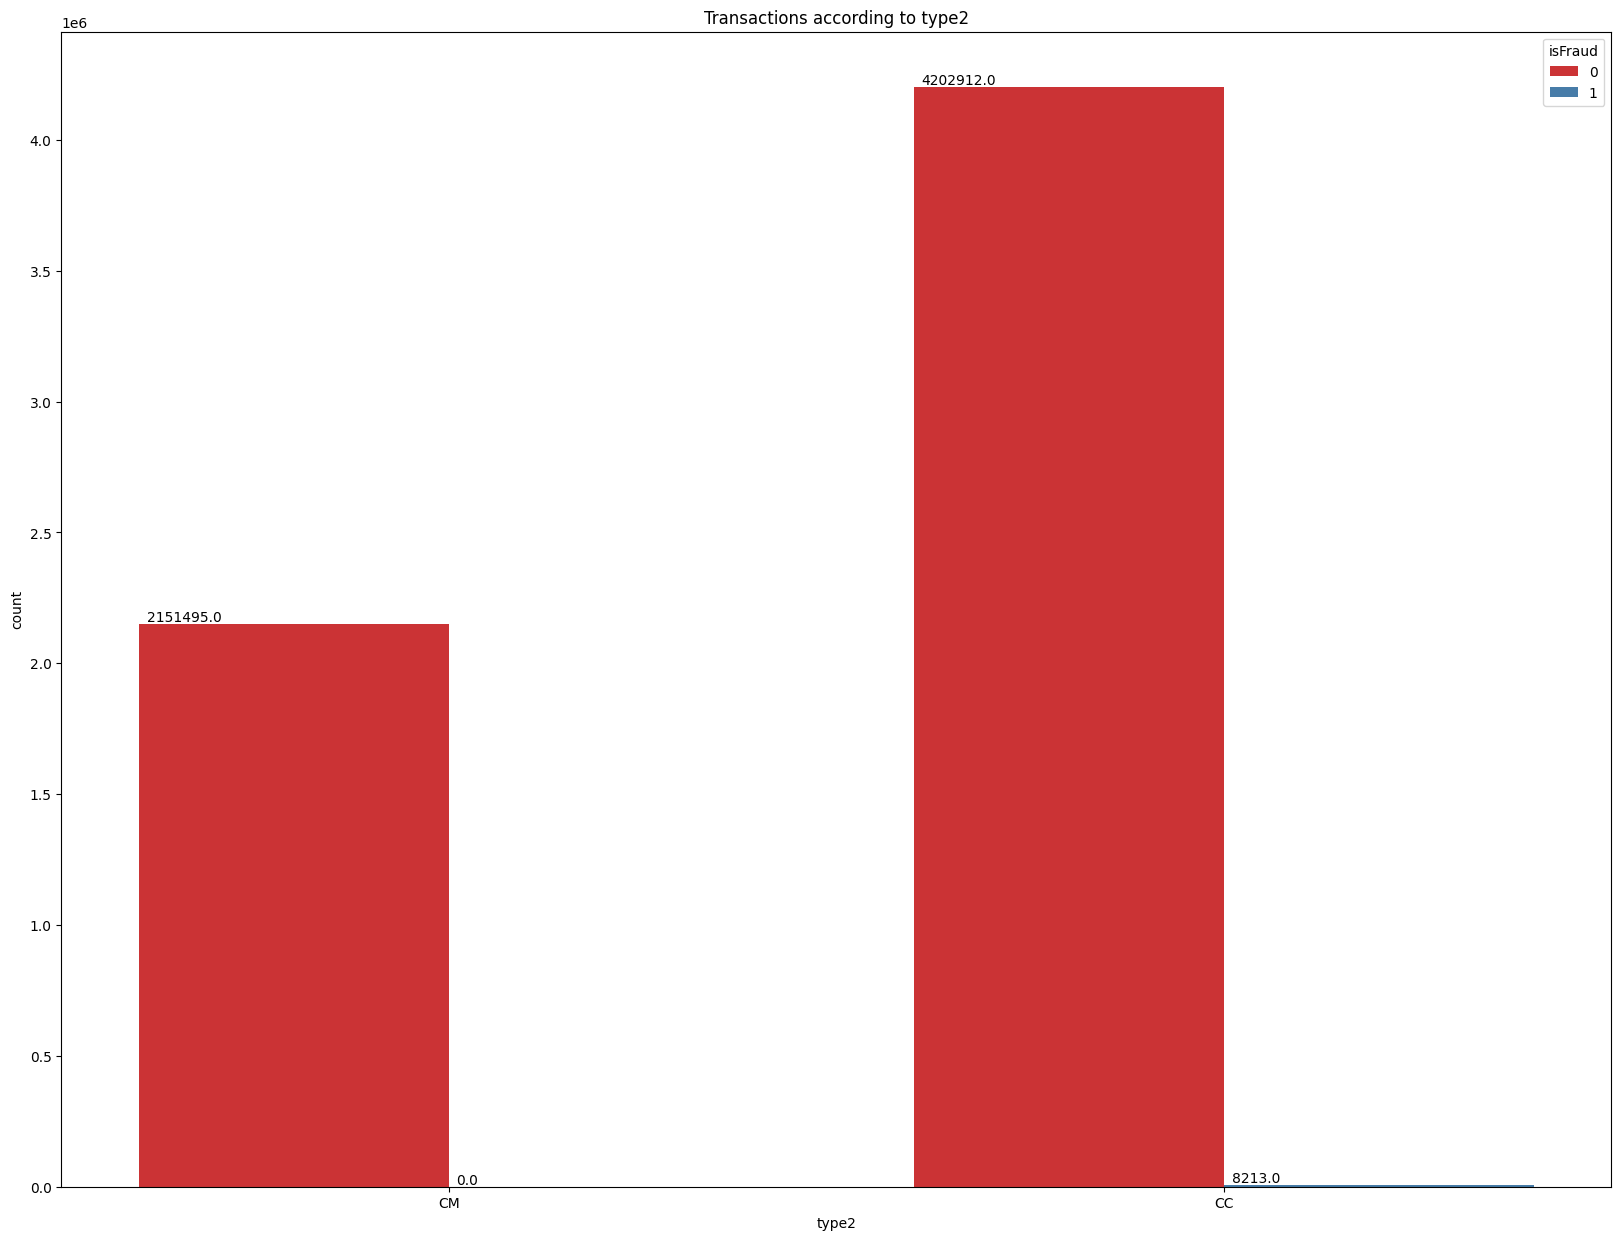

In [ ]:
plt.figure(figsize = (20,15))
ax=sns.countplot(data = data, x = "type2", hue="isFraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

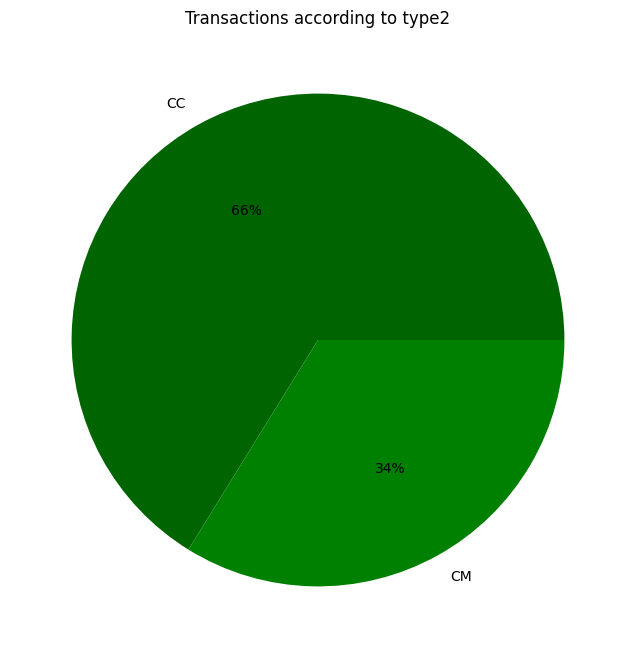

In [ ]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000']
plt.pie(data.type2.value_counts().values,labels=data.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()

**Insights**
* Most common transaction type used for transactions = **CASH_OUT** .
* Least common transaction type used for transactions = **DEBIT**.
* Most of the transactions done were **Customer to Customer** .
* Fruadulent transactions only between **Customer to Customer**.

#### Data Preprocessing

In [ ]:
# Created dummies of two categorical features: type and type2

def preprocessing(data):
  data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = False)
  column_order = ['step', 'amount', 'oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest','type_CASH_OUT',
       'type_OTHERS', 'type_TRANSFER', 'type2_CC', 'type2_CM','isFraud']
  data = data[column_order]
  return data

In [ ]:
data = preprocessing(data)

In [ ]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Sanju Sarkar/processed.csv')

#### Sampling used to handle biased (skewed) dataset.

In [ ]:
def sampling_split(data):
  from imblearn.over_sampling import SMOTE
  X_train, X_test, y_train, y_test = train_test_split(data.drop('isFraud', axis = 1), data['isFraud'], test_size = 0.3, random_state = 42)
  sm = SMOTE(random_state = 42)
  X_train, y_train = sm.fit_resample(X_train, y_train)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = sampling_split(data)

In [ ]:
target_values = data['isFraud'].unique()
minority_class = target_values[target_values.argmin()]
minority_samples = data[data['isFraud'] == minority_class]
oversampled_samples = minority_samples.sample(replace=True, n=5000)
majority_class = target_values[target_values.argmax()]
majority_samples = data[data['isFraud'] == majority_class]
undersampled_samples = majority_samples.sample(replace=False,n=5000)
unbiased_samples = pd.concat([oversampled_samples, undersampled_samples])
X_train, X_test, y_train, y_test = train_test_split(unbiased_samples.drop('isFraud', axis = 1), unbiased_samples['isFraud'], test_size = 0.3, random_state = 42)

In [ ]:
y_train.value_counts()

0    4448056
1    4448056
Name: isFraud, dtype: int64

#### Model Building

#### Converting data into arrays.

In [ ]:
X_train = np.array(X_train.reset_index(drop=True))

In [ ]:
y_train= np.array(y_train.reset_index(drop=True))

In [ ]:
X_test = np.array(X_test)

In [ ]:
y_test = np.array(y_test)

#### Implementing Adaptive XGBoost using Push and Replacement Strategy

In [ ]:
n_estimators = 30
learning_rate = 0.3
max_depth = 6
max_window_size = 1000
min_window_size = 1
detect_drift = True
AXGBp = AdaptiveXGBoostClassifier(update_strategy='push',n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,max_window_size=max_window_size,min_window_size=min_window_size,detect_drift=detect_drift)
AXGBr = AdaptiveXGBoostClassifier(update_strategy='replace',n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,max_window_size=max_window_size,min_window_size=min_window_size,detect_drift=detect_drift)
evaluator = EvaluatePrequential(pretrain_size=0,
                                show_plot=True,
                                output_file='result.csv')
from skmultiflow.data.file_stream import FileStream
# The New Data is trained on the model using stream
stream = FileStream('/content/drive/MyDrive/Sanju Sarkar/processed.csv')


Prequential Evaluation
Evaluating 1 target(s).
Evaluating...
 -------------------- [0%] [0.05s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


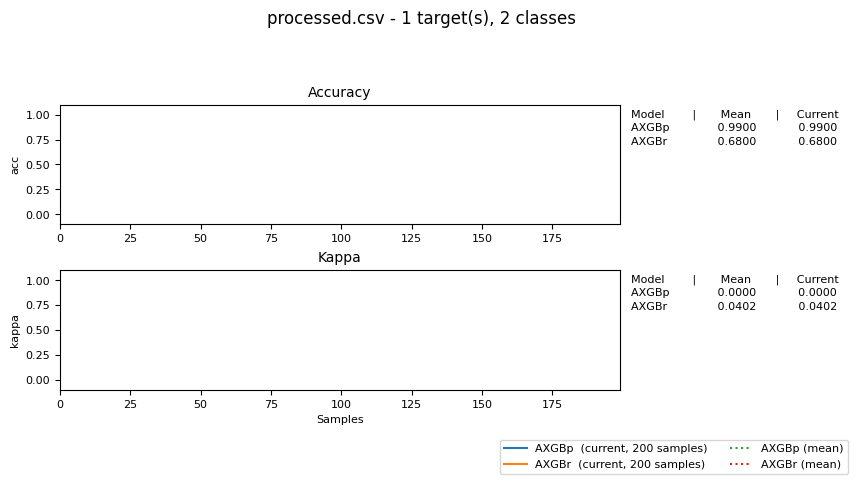

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

 #------------------- [5%] [17.77s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ##------------------ [10%] [35.67s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

 ###----------------- [15%] [57.53s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ####---------------- [20%] [75.57s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 #####--------------- [25%] [92.99s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ######-------------- [30%] [111.26s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:06:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 #######------------- [35%] [133.29s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ########------------ [40%] [150.93s]

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 #########----------- [45%] [169.00s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ##########---------- [50%] [190.11s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ###########--------- [55%] [208.43s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ############-------- [60%] [227.50s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 #############------- [65%] [245.54s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:09:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:09:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ##############------ [70%] [267.38s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:09:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:09:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ###############----- [75%] [286.73s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:09:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:09:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ################---- [80%] [310.14s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:10:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:10:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 #################--- [85%] [329.14s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:10:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:10:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ##################-- [90%] [348.40s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:10:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:10:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 ###################- [95%] [371.91s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:11:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:11:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:11:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:11:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

 #################### [100%] [392.41s]


<Figure size 640x480 with 0 Axes>

Processed samples: 20000
Mean performance:
AXGBp - Accuracy     : 0.9960
AXGBp - Kappa        : 0.0000
AXGBr - Accuracy     : 0.9879
AXGBr - Kappa        : 0.0785


[AdaptiveXGBoostClassifier(detect_drift=True, learning_rate=0.3, max_depth=6,
                           max_window_size=1000, min_window_size=1,
                           n_estimators=30, update_strategy='push'),
 AdaptiveXGBoostClassifier(detect_drift=True, learning_rate=0.3, max_depth=6,
                           max_window_size=1000, min_window_size=1,
                           n_estimators=30, update_strategy='replace')]

In [ ]:
evaluator.evaluate(stream=stream,
                   model=[AXGBp, AXGBr],
                   model_names=['AXGBp', 'AXGBr'])

In [ ]:
def train_and_predict(model,X_train, y_train, X_test):
  predictions = model.predict(X_test)
  return predictions

In [ ]:
def evaluate(y_test,y_pred):
  print("\n",metrics.classification_report(y_test,y_pred))
  confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()
  print('AUC score: ',roc_auc_score(y_test, y_pred))
  from sklearn.metrics import roc_curve
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
  plt.subplots(1, figsize=(10,10))
  plt.title('Adaptive XGB Receiver Operating Charateristic')
  plt.plot(false_positive_rate, true_positive_rate)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [ ]:
y_pred_Xp= train_and_predict(AXGBp,X_train, y_train, X_test)

In [ ]:
evaluate(y_test,y_pred_Xp)

In [ ]:
y_pred_Xr= train_and_predict(AXGBr,X_train, y_train, X_test)


               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1537
           1       0.99      0.91      0.94      1463

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



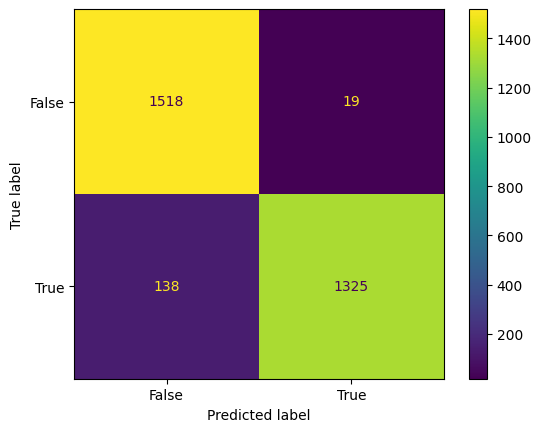

AUC score:  0.9466557652189265


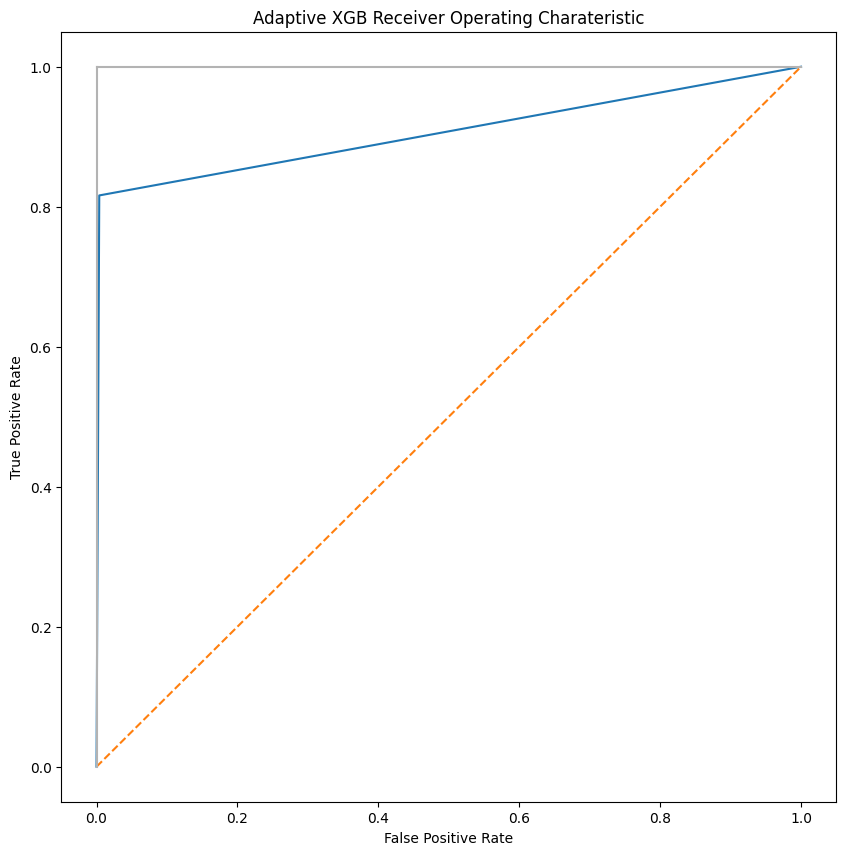

In [ ]:
evaluate(y_test,y_pred_Xr)